In [2]:
from constants import *
from data.load_data import load_arff_file_from_file_path
from clustering_algorithms.kmeans import calculate_wcss
from main import plot_clusters as plot_clustering

# We want to just test the clustering on a single dataset
# Choose the diamond9 dataset

def test_clustering(
    
    dataset_name,
    clustering_algorithm,
    approximate_adder_name,
    n_clusters,
    bit_configuration = (32, 8),
    initialisation_random_state = 42,
    maximum_iterations = 20,
    plot_clusters = False
):
    # We first load the dataset
    dataset = load_arff_file_from_file_path(DATASETS[dataset_name]['path'])
    
    # We then load the clustering algorithm
    clustering_function = CLUSTERING_ALGORITHMS[clustering_algorithm]['algorithm']
    # The clustering function has parameters (X, k, max_iters=100,  random_state=26, adder=accurate_adder, bits=(32, 4))
    # We then load the approximate adder
    adder = APPROXIMATE_ADDERS[approximate_adder_name]['adder']
    # The adder has parameters (num1, num2, total_bits, inaccurate_bits)
       
    # We then initialize the results dictionary
    
    clusters, centroids, converged = clustering_function(dataset, n_clusters, max_iters=maximum_iterations, adder=adder, random_state=initialisation_random_state, bits=bit_configuration)
    WCSS = calculate_wcss(dataset, clusters, centroids)
    
    if plot_clusters:
        plot_clustering(dataset, clusters, centroids)
    
    return WCSS, converged

(23098.213827730404, True)

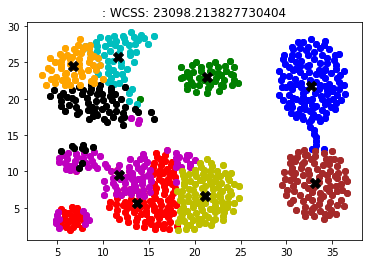

In [5]:
# test_clustering('engytime', 'KMeans++_with_adder_mod', 'accurate_adder', 2, bit_configuration=(16,5),initialisation_random_state=42, plot_clusters=True)
test_clustering('aggregation', 'KMeans++_with_adder_mod', 'BPAA2_LSP1', 9, bit_configuration=(16,10),initialisation_random_state=42, plot_clusters=True)


In [3]:
clustering_function = CLUSTERING_ALGORITHMS["KMeans++_with_adder_mod"]['algorithm']

In [7]:
import numpy as np

def compare_clusters(clusters_A, clusters_B):
    """
    Compare clusters_A and clusters_B and compute set differences for the most similar centroids.
    
    Parameters:
        clusters_A (dict): Dictionary with centroids (tuple) as keys and cluster points (arrays) as values.
        clusters_B (dict): Dictionary with centroids (tuple) as keys and cluster points (arrays) as values.
        
    Returns:
        dict: A new dictionary where keys are concatenated tuples of centroids (from A and B) 
              and values are arrays of set differences between the corresponding clusters.
    """
    clusters_difference = {}

    # Iterate over centroids in clusters_A
    for centroid_A, points_A in clusters_A.items():
        # Find the most similar centroid in clusters_B
        most_similar_centroid_B = None
        min_distance = float('inf')

        for centroid_B in clusters_B.keys():
            # Compute similarity (here, Euclidean distance)
            distance = np.linalg.norm(np.array(centroid_A) - np.array(centroid_B))
            if distance < min_distance:
                min_distance = distance
                most_similar_centroid_B = centroid_B

        # Perform set difference between the clusters
        points_B = clusters_B[most_similar_centroid_B]
        set_diff = np.setdiff1d(points_A, points_B)

        # Add the result to the dictionary
        key = (tuple(centroid_A), tuple(most_similar_centroid_B))
        clusters_difference[key] = set_diff

    return clusters_difference


In [9]:
import matplotlib.pyplot as plt

for dataset_name in DATASETS.keys():
    dataset = load_arff_file_from_file_path(DATASETS[dataset_name]['path'])
    n_clusters = DATASETS[dataset_name]['clusters']

    bit_configuration = (16, 7)

    clusters_A, centroids_A, _ = clustering_function(dataset, n_clusters, adder = APPROXIMATE_ADDERS['accurate_adder']['adder'], bits=bit_configuration)
    clusters_B, centroids_B, _ = clustering_function(dataset, n_clusters, max_iters=1000, adder=APPROXIMATE_ADDERS['BPAA2_LSP1']['adder'], bits=bit_configuration, threshold=0.01)

    wcssA = calculate_wcss(dataset, clusters_A, centroids_A)
    wcssB = calculate_wcss(dataset, clusters_B, centroids_B)
    # print(f'WCSS difference between accurate adder and BPAA2_LSP1: {wcssA - wcssB}')

    def clustering_to_dict(clusters, centroids):
        return {
            tuple(centroid): cluster for centroid, cluster in zip(centroids, clusters)
        }

    cluster_dict_A = clustering_to_dict(clusters_A, centroids_A)
    cluster_dict_B = clustering_to_dict(clusters_B, centroids_B)
    clusters_diff = compare_clusters(cluster_dict_A, cluster_dict_B)
    
    print(f"\nNumber of clusters for {dataset_name}: {n_clusters}")
    for centroids_tuple in clusters_diff.keys():
        print(f"{centroids_tuple[0]} vs {centroids_tuple[1]}")
        


    different_points_idx = [idx for cluster in clusters_diff.values() for idx in cluster]
    same_points_idx = np.setdiff1d(np.arange(len(dataset)), different_points_idx)
    same_points = dataset[same_points_idx]
    different_points = dataset[different_points_idx]

    # print(
    #     f"Number of points in different clusters for {dataset_name}: {len(different_points)}\n",
    #     different_points
    # )

    # Adjust size of the plot
    plt.figure(figsize=(10, 10))

    # draw a scatter plot of the same and different points
    plt.scatter(same_points[:,0], same_points[:,1], color='blue', label='Same points')
    plt.scatter(different_points[:,0], different_points[:,1], color='red', label='Different points')
    plt.legend()
    plt.title('Comparison of clustering results of BPAA-LSP1 and accurate adder')
    # Save the plot
    path = "results/results_BPAA_LSP1/diff_plot_acc_vs_BPAA_" + dataset_name + ".png"
    plt.savefig(path)
    # remove the plot
    plt.clf()


Number of clusters for aggregation: 7
(12.325000000000001, 4.913076923076923) vs (11.77888283378746, 5.188692098092642)
(21.543333333333326, 23.003333333333334) vs (21.413043478260878, 23.126086956521732)
(9.066783216783211, 23.927272727272726) vs (9.021126760563382, 23.894014084507038)
(33.142788461538466, 8.793750000000001) vs (33.142788461538466, 8.79375)
(32.69453124999999, 22.137890624999997) vs (32.69453125000002, 22.137890625000022)
(9.54736842105263, 13.686184210526317) vs (9.6140625, 13.829017857142853)
(19.710185185185185, 7.923148148148148) vs (19.661403508771915, 7.573586744639374)

Number of clusters for diamond9: 9
(-0.9897886494287429, 2.0015847745039044) vs (-0.9891802828589432, 1.9925448655913922)
(2.9942383183183137, 1.995745075075077) vs (2.9942383183183043, 1.995745075075067)
(-0.967912315366431, 0.016157058123522444) vs (-0.9748862501100335, 0.010416960507859105)
(0.9900418529940127, 3.9752097604790375) vs (0.9900418529940113, 3.97520976047903)
(1.0113993100420953

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [6]:
clusters_diff


{((12.325000000000001, 4.913076923076923),
  (16.369127040454224,
   6.09293825408091)): array([209, 210, 229, 230, 231, 232, 233, 234, 235, 239, 240, 241, 242,
        243, 244, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764,
        765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777,
        778, 779, 780, 781, 782, 783, 784, 785, 786, 787]),
 ((21.543333333333326, 23.003333333333334),
  (21.441865079365034, 22.9731150793651)): array([], dtype=int32),
 ((9.066783216783211, 23.927272727272726),
  (9.181925968768054, 23.4035280508965)): array([], dtype=int32),
 ((33.142788461538466, 8.793750000000001),
  (33.13719512195119,
   8.4235928705441)): array([560, 561, 576, 577, 578, 579, 580]),
 ((32.69453124999999, 22.137890624999997),
  (32.7244444444444, 21.701548821548784)): array([], dtype=int32),
 ((9.54736842105263, 13.686184210526317),
  (9.721418826739441,
   8.973703956343815)): array([105, 109, 112, 113, 114, 150, 151, 152, 154, 156, 161, 162, 165]),
 ((19.7101